##DEPENDENCIES

In [ ]:
import os
import csv
import re
import warnings
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from google.colab import files
from google.colab import userdata
import random
import torch
import seaborn as sns


In [ ]:
# Environment setup
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TOKENIZERS_PARALLELISM"] = "false"
warnings.filterwarnings("ignore")

In [ ]:
def set_all_seeds(seed):
       """Set all seeds for reproducibility"""

       random.seed(seed)
       np.random.seed(seed)
       torch.manual_seed(seed)
       if torch.cuda.is_available():
           torch.cuda.manual_seed(seed)
           torch.cuda.manual_seed_all(seed)
       torch.backends.cudnn.deterministic = True
       torch.backends.cudnn.benchmark = False

In [ ]:
set_all_seeds(56)

In [ ]:
my_secret_key= userdata.get('HF_TOKEN')

In [ ]:
print(f"\nCUDA available: {torch.cuda.is_available()}")



CUDA available: True


##COMMON FUNCTIONS

In [ ]:
def plot_dataset_distribution(train_df, val_df, test_df, labels=['Train', 'Validation', 'Test'], title='Dataset Distribution'):
    """
    Plots a pie chart showing the distribution of three datasets.

    Parameters:
    - train_df: Training dataset (DataFrame)
    - val_df: Validation dataset (DataFrame)
    - test_df: Test dataset (DataFrame)
    - labels: List of labels for the pie chart slices
    - title: Title of the pie chart
    """
    sizes = [len(train_df), len(val_df), len(test_df)]

    plt.figure(figsize=(5,5))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140,
            colors=['#66b3ff','#99ff99','#ff9999'], wedgeprops={'edgecolor':'black'})
    plt.title(title, fontsize=14)
    plt.show()

In [ ]:
def plot_dataset_distribution_train_test(train_df, test_df, labels=['Train', 'Test'], title='Dataset Distribution'):
    """
    Plots a pie chart showing the distribution of three datasets.

    Parameters:
    - train_df: Training dataset (DataFrame)
    - test_df: Test dataset (DataFrame)
    - labels: List of labels for the pie chart slices
    - title: Title of the pie chart
    """
    sizes = [len(train_df), len(test_df)]

    plt.figure(figsize=(5,5))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140,
            colors=['#66b3ff','#ff9999'], wedgeprops={'edgecolor':'black'})
    plt.title(title, fontsize=14)
    plt.show()

In [ ]:
def plot_label_distribution(df, title):
    """
    Plots a bar chart showing the distribution of labels in a dataset.

    Parameters:
    - df: Dataset (DataFrame)
    - title: Title of the bar chart
    """
    sns.set_style("whitegrid")
    colors = ['#66b3ff','#99ff99','#ff9999']
    plt.figure(figsize=(6,4))
    ax = sns.countplot(x='label', data=df, palette=colors, order=['not aggressive','covertly aggressive','overtly aggressive'])

    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width()/2., height + 0.2, int(height), ha="center", fontsize=10)

    plt.title(title, fontsize=14)
    plt.ylabel('Count', fontsize=12)
    plt.xlabel('Label', fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.ylim(0, max(df['label'].value_counts())*1.15)
    plt.show()

In [ ]:
def analyze_dataset(df, dataset_name):
    """
    Analyzes a single dataset by checking for NULL values and displaying label distributions.

    Args:
        df (pd.DataFrame): A Pandas DataFrame to analyze.
        dataset_name (str): Name of the dataset for display purposes.

    Returns:
        None
    """
    print(f"NULL values in {dataset_name} dataframe:")
    print(df.isnull().sum())

    print(f"\nLabel distribution for {dataset_name}:")
    if 'label' in df.columns:
        print(df['label'].value_counts())
    else:
        print("No 'label' column found in this dataset.")

    print(f"\nDataset shape: {df.shape}")

    print(f"\nData types:")
    print(df.dtypes)
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
    if len(numerical_cols) > 0:
        print(f"\nBasic statistics for numerical columns:")
        print(df[numerical_cols].describe())

    print("-" * 50)

In [ ]:
def preprocess_text(text):
    """
    Preprocess text for cyberbullying and aggression detection
    """
    aggression_emojis = {


      "😡": "[ANGRY_EMOJI]",
      "🤬": "[SWEARING_EMOJI]",
      "😠": "[MAD_EMOJI]",
      "💢": "[ANGER_SYMBOL_EMOJI]",
      "😤": "[HUFFING_ANGRY_EMOJI]",

      "👊": "[PUNCH_EMOJI]",
      "✊": "[FIST_EMOJI]",
      "🖕": "[MIDDLE_FINGER_EMOJI]",
      "🔪": "[KNIFE_EMOJI]",
      "🗡️": "[SWORD_EMOJI]",
      "💣": "[BOMB_EMOJI]",

      "💀": "[SKULL_EMOJI]",
      "☠️": "[SKULL_CROSSBONES_EMOJI]",
      "⚰️": "[COFFIN_EMOJI]",

      "🙄": "[EYEROLL_EMOJI]",
      "🤡": "[CLOWN_EMOJI]",
      "🤮": "[VOMIT_EMOJI]",
      "🤢": "[NAUSEA_EMOJI]",
      "💩": "[POO_EMOJI]",
      "🗑️": "[TRASH_EMOJI]",

      "😂": "[CRYING_LAUGH_EMOJI]",
      "🤣": "[ROLLING_LAUGH_EMOJI]",
      "😹": "[CAT_LAUGH_EMOJI]",
      "😆": "[SQUINTING_LAUGH_EMOJI]",
      "😭": "[LOUD_CRYING_EMOJI]",

      "🍆": "[EGGPLANT_EMOJI]",
      "🍑": "[PEACH_EMOJI]",
      "💦": "[SWEAT_EMOJI]",
      "👅": "[TONGUE_EMOJI]",

      "❌": "[CROSS_EMOJI]",
      "🚫": "[BANNED_EMOJI]",
      "👎": "[THUMBS_DOWN_EMOJI]",

      "🙃": "[UPSIDE_DOWN_EMOJI]",
      "😏": "[SMIRK_EMOJI]",

      "👹": "[DEMON_EMOJI]",
      "👺": "[GOBLIN_EMOJI]",

      "👏": "[SLOW_CLAP_EMOJI]",

      "🐷": "[PIG_EMOJI]",
      "🐒": "[MONKEY_EMOJI]",
      "🐍": "[SNAKE_EMOJI]",
      "⚠️": "[WARNING_EMOJI]",
      "🚨": "[ALARM_EMOJI]"
      }

    text = re.sub(r'http\S+|www\.\S+', '[URL]', text)

    text = re.sub(r'https?://\S+|www\.\S+|\S+\.\w{2,}\S*', '[URL]', text)
    text = re.sub(r'@\w+', '[USER]', text)
    text = re.sub(r'#\w+', '[HASHTAG]', text)
    text = re.sub(r'@MASK', '[USER]', text)

    for emoji, token in aggression_emojis.items():
        text = text.replace(emoji, token)

    text = re.sub(r'[^a-zA-Z\s\'\"\!\?\.\[\]]', '', text)
    text = re.sub(r'!{4,}', '!!!', text)
    text = re.sub(r'\?{4,}', '???', text)
    text = re.sub(r'\.{4,}', '...', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [ ]:
def has_devanagari_script(text):
    """Only filter text with actual Hindi script"""
    if pd.isna(text):
        return False
    return bool(re.search(r'[\u0900-\u097F]', str(text)))

## D1

In [ ]:
#upload D1
print("Please upload files for D1 train dataset:")
d1_train= files.upload()
d1_train= next(iter(d1_train))
d1_train=pd.read_csv(d1_train)


print("Please upload files for D1 val dataset:")
d1_val= files.upload()
d1_val= next(iter(d1_val))
d1_val=pd.read_csv(d1_val)

print("Please upload files for D1 test dataset:")
d1_test= files.upload()
d1_test= next(iter(d1_test))
d1_test=pd.read_csv(d1_test)

Please upload files for D1 train dataset:


Saving new_twitter_election_train_set.csv to new_twitter_election_train_set.csv
Please upload files for D1 val dataset:


Saving new_twitter_election_dev_set.csv to new_twitter_election_dev_set.csv
Please upload files for D1 test dataset:


Saving new_twitter_election_test_set.csv to new_twitter_election_test_set.csv


In [ ]:
print("Visualize head of D1 train dataset:")
d1_train.head()



Visualize head of D1 train dataset:


,Sentence,Label
0,"""Asked if these files of historic value were s...",0
1,I have to say this. Without a civilian governm...,0
2,Ladies and Gentlemen This man wants to get awa...,2
3,Just curious - are the BJP leaders sitting on ...,1
4,US President Barack Obama congratulates @MASK ...,0


In [ ]:
print("Visualize head of D1 val dataset:")
d1_val.head()


Visualize head of D1 val dataset:


,Sentence,Label
0,No diary entry at the time of detention no inf...,1
1,Paralysis inside Parliament not in Policy. You...,1
2,Time to think whether we need to have a negati...,1
3,Despite being in power for decades Congress di...,2
4,There is no word 'Delay' in our Government. 'D...,0


In [ ]:
print("Visualize head of D1 test dataset:")
d1_test.head()

Visualize head of D1 test dataset:


,Sentence,Label
0,(Hold regular town hall/ Chaupals) @MASK Modi ...,0
1,In Bihar. East & West Champaran. The land of f...,0
2,The people of India gave these parties the opp...,1
3,When Rahul Gandhi tore the copy of Ordinance h...,2
4,BJP's high-pitch negative propaganda (like the...,1


from matplotlib import pyplot as plt
_df_0['Label'].plot(kind='hist', bins=20, title='Label')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('Sentence').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['Label'].plot(kind='line', figsize=(8, 4), title='Label')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_3['Sentence'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_3, x='Label', y='Sentence', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
# Map numeric labels to descriptive labels
label_mapping_d1 = {0: 'not aggressive', 1: 'covertly aggressive', 2: 'overtly aggressive'}
d1_train['label'] = d1_train['Label'].map(label_mapping_d1)
d1_val['label'] = d1_val['Label'].map(label_mapping_d1)
d1_test['label'] = d1_test['Label'].map(label_mapping_d1)

d1_train.drop(columns=['Label'], inplace=True)
d1_val.drop(columns=['Label'], inplace=True)
d1_test.drop(columns=['Label'], inplace=True)

d1_train=d1_train.rename(columns={'Sentence':'text'})

d1_val=d1_val.rename(columns={'Sentence':'text'})

d1_test=d1_test.rename(columns={'Sentence':'text'})


In [ ]:
d1_train.head()

,text,label
0,"""Asked if these files of historic value were s...",not aggressive
1,I have to say this. Without a civilian governm...,not aggressive
2,Ladies and Gentlemen This man wants to get awa...,overtly aggressive
3,Just curious - are the BJP leaders sitting on ...,covertly aggressive
4,US President Barack Obama congratulates @MASK ...,not aggressive


In [ ]:
analyze_dataset(d1_train, "D1 Train")
analyze_dataset(d1_val, "D1 Validation")
analyze_dataset(d1_test, "D1 Test")

NULL values in D1 Train dataframe:
text     0
label    0
dtype: int64

Label distribution for D1 Train:
label
not aggressive         794
covertly aggressive    414
overtly aggressive     391
Name: count, dtype: int64

Dataset shape: (1599, 2)

Data types:
text     object
label    object
dtype: object
--------------------------------------------------
NULL values in D1 Validation dataframe:
text     0
label    0
dtype: int64

Label distribution for D1 Validation:
label
not aggressive         99
covertly aggressive    52
overtly aggressive     49
Name: count, dtype: int64

Dataset shape: (200, 2)

Data types:
text     object
label    object
dtype: object
--------------------------------------------------
NULL values in D1 Test dataframe:
text     0
label    0
dtype: int64

Label distribution for D1 Test:
label
not aggressive         99
covertly aggressive    52
overtly aggressive     49
Name: count, dtype: int64

Dataset shape: (200, 2)

Data types:
text     object
label    object
dtype:

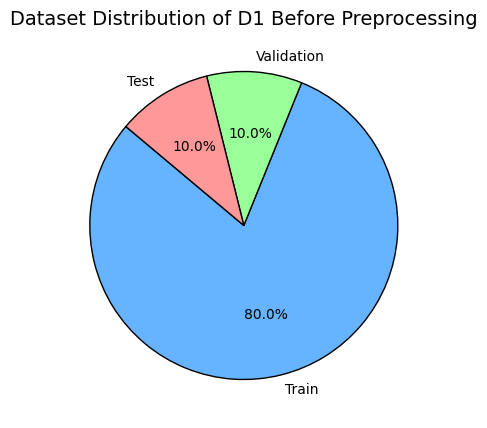

In [ ]:
plot_dataset_distribution(d1_train, d1_val, d1_test, labels=['Train', 'Validation', 'Test'],
                          title='Dataset Distribution of D1 Before Preprocessing')

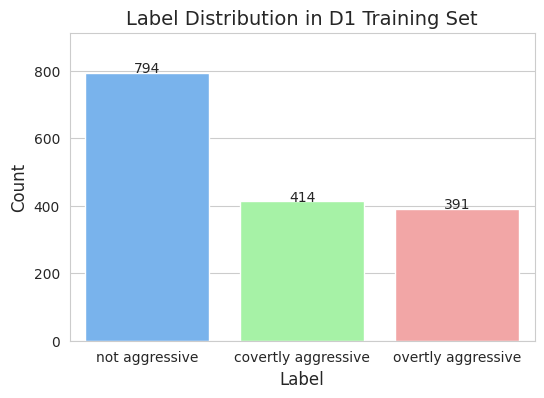

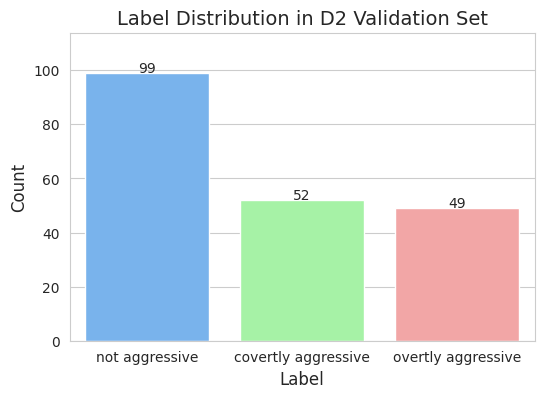

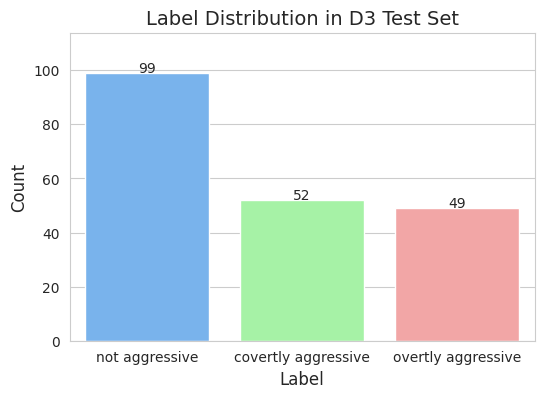

In [ ]:

# Plot for each dataset
plot_label_distribution(d1_train, 'Label Distribution in D1 Training Set')
plot_label_distribution(d1_val, 'Label Distribution in D2 Validation Set')
plot_label_distribution(d1_test, 'Label Distribution in D3 Test Set')

In [ ]:

d1_train['has_devanagari'] = d1_train['text'].apply(has_devanagari_script)
d1_train_eng= d1_train[d1_train['has_devanagari'] == False].copy()

devanagari_filtered_d1_train = d1_train[d1_train['has_devanagari'] == True].copy()
d1_train = d1_train_eng.drop(['has_devanagari', 'is_english'], axis=1, errors='ignore').reset_index(drop=True)

d1_test['has_devanagari'] = d1_test['text'].apply(has_devanagari_script)
d1_test_eng = d1_test[d1_test['has_devanagari'] == False].copy()

devanagari_filtered_d1_test = d1_test[d1_test['has_devanagari'] == True].copy()
d1_test = d1_test_eng.drop(['has_devanagari', 'is_english'], axis=1, errors='ignore').reset_index(drop=True)


In [ ]:
print("Number of devanagari sentences  removed", len(devanagari_filtered_d1_train))
print("Number of devanagari sentences  removed", len(devanagari_filtered_d1_test))

Number of devanagari sentences  removed 0
Number of devanagari sentences  removed 0


In [ ]:
#preprocessing of datasets
d1_train['text']=d1_train['text'].apply(preprocess_text)
d1_val['text']=d1_val['text'].apply(preprocess_text)
d1_test['text']=d1_test['text'].apply(preprocess_text)
d1_train = d1_train.dropna(subset=['text', 'label']).reset_index(drop=True)
d1_val = d1_val.dropna(subset=['text', 'label']).reset_index(drop=True)
d1_test = d1_test.dropna(subset=['text', 'label']).reset_index(drop=True)

In [ ]:
analyze_dataset(d1_train, "D1 Train")
analyze_dataset(d1_val, "D1 Validation")
analyze_dataset(d1_test, "D1 Test")

NULL values in D1 Train dataframe:
text     0
label    0
dtype: int64

Label distribution for D1 Train:
label
not aggressive         794
covertly aggressive    414
overtly aggressive     391
Name: count, dtype: int64

Dataset shape: (1599, 2)

Data types:
text     object
label    object
dtype: object
--------------------------------------------------
NULL values in D1 Validation dataframe:
text     0
label    0
dtype: int64

Label distribution for D1 Validation:
label
not aggressive         99
covertly aggressive    52
overtly aggressive     49
Name: count, dtype: int64

Dataset shape: (200, 2)

Data types:
text     object
label    object
dtype: object
--------------------------------------------------
NULL values in D1 Test dataframe:
text     0
label    0
dtype: int64

Label distribution for D1 Test:
label
not aggressive         99
covertly aggressive    52
overtly aggressive     49
Name: count, dtype: int64

Dataset shape: (200, 2)

Data types:
text     object
label    object
dtype:

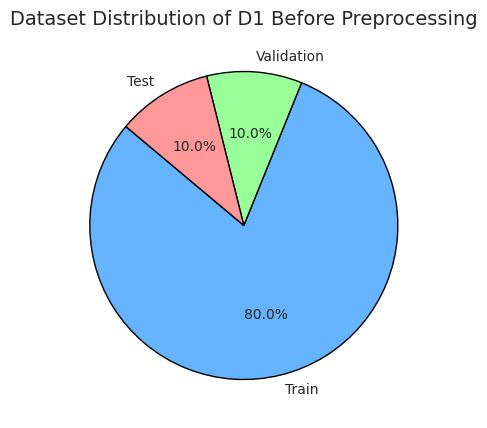

In [ ]:
plot_dataset_distribution(d1_train, d1_val, d1_test, labels=['Train', 'Validation', 'Test'],
                          title='Dataset Distribution of D1 Before Preprocessing')

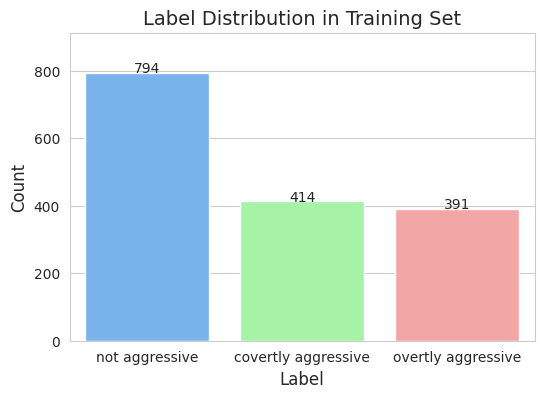

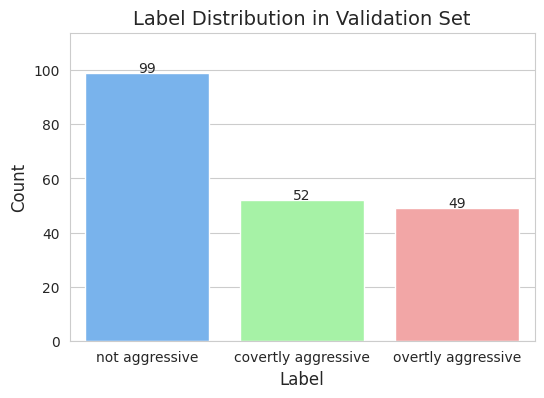

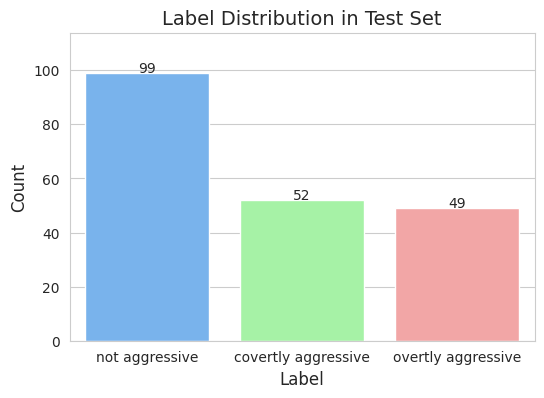

In [ ]:
plot_label_distribution(d1_train, 'Label Distribution in Training Set')
plot_label_distribution(d1_val, 'Label Distribution in Validation Set')
plot_label_distribution(d1_test, 'Label Distribution in Test Set')

##D2


In [ ]:
#upload D2
print("Please upload files for D2 train dataset:")
d2_train= files.upload()
d2_train= next(iter(d2_train))
d2_train=pd.read_csv(d2_train)


print("Please upload files for D2 val dataset:")
d2_val= files.upload()
d2_val= next(iter(d2_val))
d2_val=pd.read_csv(d2_val)

print("Please upload files for D2 test dataset:")
d2_test= files.upload()
d2_test= next(iter(d2_test))
d2_test=pd.read_csv(d2_test)

Please upload files for D2 train dataset:


Saving Tagg-train.csv to Tagg-train.csv
Please upload files for D2 val dataset:


Saving Tagg-val.csv to Tagg-val.csv
Please upload files for D2 test dataset:


Saving Tagg-test.csv to Tagg-test.csv


In [ ]:
print("Visualize head of D2 train dataset:")
d2_train.head()

Visualize head of D2 train dataset:


,Unnamed: 0.1,Unnamed: 0,id,tweet,aggression,codemixed
0,6512,6512,1.585708e+18,"@MASK Tector (Barbados Royals), Little (Pretor...",1,0
1,8619,8619,1.556707e+18,"In 1942, when the Quit India Movement began, G...",1,1
2,2629,2629,1.575702e+18,@MASK 1/ Totally Disagree India's IT Industry...,0,1
3,4605,4605,1.577233e+18,@MASK Bahut achaa kam he love jihad jayda hote he,1,1
4,2659,2659,1.575518e+18,@MASK @MASK It is Pride moment collectively fo...,0,0


In [ ]:
print("Visualize head of D2 validation dataset:")
d2_val.head()

Visualize head of D2 validation dataset:


,Unnamed: 0.1,Unnamed: 0,id,tweet,aggression,codemixed
0,9621,9621,1.579366e+18,"In NCR, there is still a lot of unsold stock s...",0,0
1,5668,5668,1.581137e+18,GN Saibaba will not get his 5 years back. Than...,1,0
2,5234,5234,1.583588e+18,@MASK @MASK Capitalists use corruption or any ...,1,0
3,8704,8704,1.562422e+18,Sukanta is a 50-50 Sanghi. Sometimes his Benga...,2,1
4,9966,9966,1.583575e+18,@MASK @MASK @MASK His agenda is dangerous. He ...,2,0


In [ ]:
print("Visualize head of D2 test dataset:")
d2_test.head()

Visualize head of D2 test dataset:


,Unnamed: 0.1,Unnamed: 0,id,tweet,aggression,codemixed
0,1254,1254,1.568987e+18,This is one example which proves feminists wer...,2,0
1,3266,3266,1.583548e+18,@MASK The weird part to me is how that wasn't ...,0,0
2,5973,5973,1.585857e+18,@MASK @MASK @MASK I have said it before this g...,0,0
3,9555,9555,1.579782e+18,@MASK Demonetisation,0,0
4,4690,4690,1.577152e+18,@MASK Organised Gold smuggling is another FACT...,1,0


In [ ]:
d2_train = d2_train[['tweet', 'aggression', 'codemixed']]
d2_val = d2_val[['tweet', 'aggression', 'codemixed']]
d2_test = d2_test[['tweet', 'aggression', 'codemixed']]


In [ ]:
# Map numeric labels to descriptive labels
label_mapping_d1 = {0: 'not aggressive', 1: 'covertly aggressive', 2: 'overtly aggressive'}
d2_train['label'] = d2_train['aggression'].map(label_mapping_d1)
d2_val['label'] = d2_val['aggression'].map(label_mapping_d1)
d2_test['label'] = d2_test['aggression'].map(label_mapping_d1)

d2_train=d2_train.rename(columns={'tweet':'text'})

d2_val=d2_val.rename(columns={'tweet':'text'})

d2_test=d2_test.rename(columns={'tweet':'text'})

d2_train=d2_train.drop(columns=['aggression'])
d2_val=d2_val.drop(columns=['aggression'])
d2_test=d2_test.drop(columns=['aggression'])


In [ ]:
d2_train.head()

,text,codemixed,label
0,"@MASK Tector (Barbados Royals), Little (Pretor...",0,covertly aggressive
1,"In 1942, when the Quit India Movement began, G...",1,covertly aggressive
2,@MASK 1/ Totally Disagree India's IT Industry...,1,not aggressive
3,@MASK Bahut achaa kam he love jihad jayda hote he,1,covertly aggressive
4,@MASK @MASK It is Pride moment collectively fo...,0,not aggressive


In [ ]:
analyze_dataset(d2_train, "D2 Train")
analyze_dataset(d2_val, "D2 Validation")
analyze_dataset(d2_test, "D2 Test")

NULL values in D2 Train dataframe:
text         0
codemixed    0
label        0
dtype: int64

Label distribution for D2 Train:
label
not aggressive         3369
covertly aggressive    2187
overtly aggressive     1644
Name: count, dtype: int64

Dataset shape: (7200, 3)

Data types:
text         object
codemixed     int64
label        object
dtype: object

Basic statistics for numerical columns:
         codemixed
count  7200.000000
mean      0.459444
std       0.498387
min       0.000000
25%       0.000000
50%       0.000000
75%       1.000000
max       1.000000
--------------------------------------------------
NULL values in D2 Validation dataframe:
text         0
codemixed    0
label        0
dtype: int64

Label distribution for D2 Validation:
label
not aggressive         374
covertly aggressive    243
overtly aggressive     183
Name: count, dtype: int64

Dataset shape: (800, 3)

Data types:
text         object
codemixed     int64
label        object
dtype: object

Basic statistics f

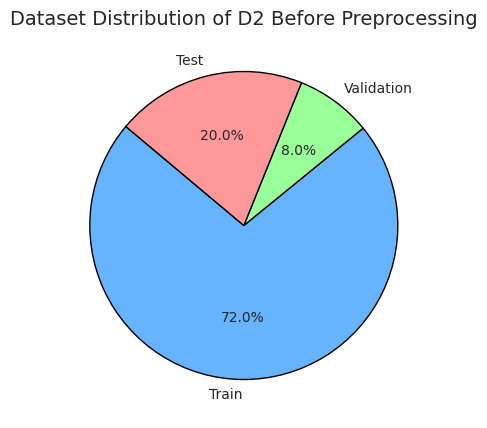

In [ ]:
plot_dataset_distribution(d2_train, d2_val, d2_test, labels=['Train', 'Validation', 'Test'],
                          title='Dataset Distribution of D2 Before Preprocessing')

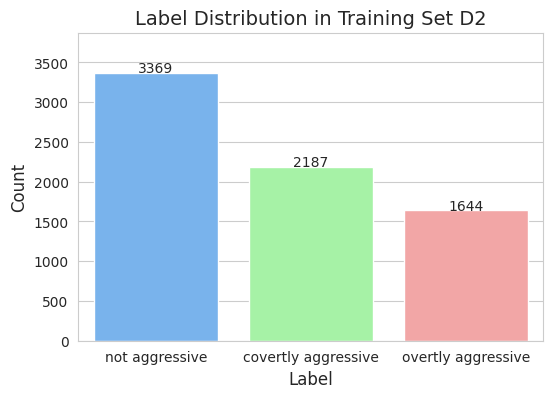

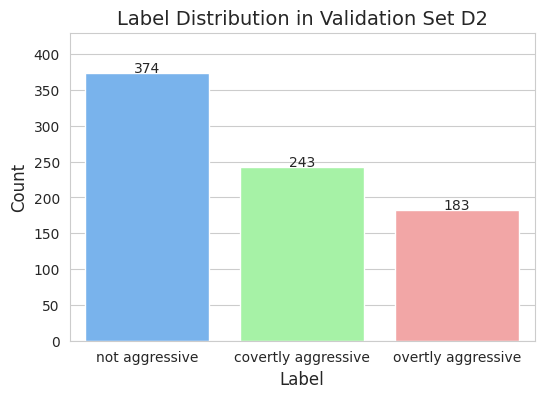

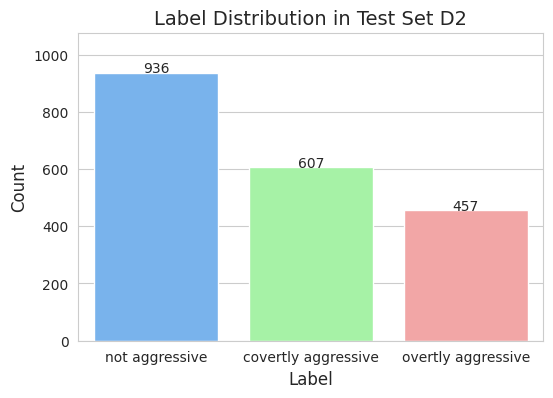

In [ ]:

# Plot for each dataset
plot_label_distribution(d2_train, 'Label Distribution in Training Set D2')
plot_label_distribution(d2_val, 'Label Distribution in Validation Set D2')
plot_label_distribution(d2_test, 'Label Distribution in Test Set D2')

In [ ]:
# keep only rows where codemixed is 0 as ,1 means it is multilingual
d2_train = d2_train[d2_train['codemixed'] == 0]
d2_val = d2_val[d2_val['codemixed'] == 0]
d2_test = d2_test[d2_test['codemixed'] == 0]

# Reset the index if you want clean sequential indices
d2_train = d2_train.reset_index(drop=True)
d2_val = d2_val.reset_index(drop=True)
d2_test = d2_test.reset_index(drop=True)

d2_train=d2_train.drop(columns=['codemixed'])
d2_val=d2_val.drop(columns=['codemixed'])
d2_test=d2_test.drop(columns=['codemixed'])


In [ ]:
d2_train.head()

,text,label
0,"@MASK Tector (Barbados Royals), Little (Pretor...",covertly aggressive
1,@MASK @MASK It is Pride moment collectively fo...,not aggressive
2,Feels like secularism doesn't mean the same wh...,covertly aggressive
3,@MASK @MASK He is a liar like everyone in your...,overtly aggressive
4,@MASK @MASK Marital rape was legal in the UK u...,not aggressive


In [ ]:

d2_train['has_devanagari'] = d2_train['text'].apply(has_devanagari_script)
d2_train_eng= d2_train[d2_train['has_devanagari'] == False].copy()

devanagari_filtered_d2_train = d2_train[d2_train['has_devanagari'] == True].copy()
d2_train = d2_train_eng.drop(['has_devanagari', 'is_english'], axis=1, errors='ignore').reset_index(drop=True)

d2_test['has_devanagari'] = d2_test['text'].apply(has_devanagari_script)
d2_test_eng = d2_test[d2_test['has_devanagari'] == False].copy()

devanagari_filtered_d2_test = d2_test[d2_test['has_devanagari'] == True].copy()
d2_test = d2_test_eng.drop(['has_devanagari', 'is_english'], axis=1, errors='ignore').reset_index(drop=True)

In [ ]:
print("Number of devanagari sentences  removed", len(devanagari_filtered_d2_train))
print("Number of devanagari sentences  removed", len(devanagari_filtered_d2_test))

Number of devanagari sentences  removed 3
Number of devanagari sentences  removed 1


In [ ]:
#preprocessing of datasets
d2_train['text']=d2_train['text'].apply(preprocess_text)
d2_val['text']=d2_val['text'].apply(preprocess_text)
d2_test['text']=d2_test['text'].apply(preprocess_text)

d2_train = d2_train.dropna(subset=['text', 'label']).reset_index(drop=True)
d2_val = d2_val.dropna(subset=['text', 'label']).reset_index(drop=True)
d2_test = d2_test.dropna(subset=['text', 'label']).reset_index(drop=True)

In [ ]:
analyze_dataset(d2_train, "D2 Train")
analyze_dataset(d2_val, "D2 Validation")
analyze_dataset(d2_test, "D2 Test")

NULL values in D2 Train dataframe:
text     0
label    0
dtype: int64

Label distribution for D2 Train:
label
not aggressive         1864
covertly aggressive    1211
overtly aggressive      814
Name: count, dtype: int64

Dataset shape: (3889, 2)

Data types:
text     object
label    object
dtype: object
--------------------------------------------------
NULL values in D2 Validation dataframe:
text     0
label    0
dtype: int64

Label distribution for D2 Validation:
label
not aggressive         212
covertly aggressive    137
overtly aggressive      84
Name: count, dtype: int64

Dataset shape: (433, 2)

Data types:
text     object
label    object
dtype: object
--------------------------------------------------
NULL values in D2 Test dataframe:
text     0
label    0
dtype: int64

Label distribution for D2 Test:
label
not aggressive         523
covertly aggressive    366
overtly aggressive     233
Name: count, dtype: int64

Dataset shape: (1122, 2)

Data types:
text     object
label    obj

In [ ]:
# Combine all datasets
combined_df_t2= pd.concat([d2_val, d2_test], ignore_index=True)

d2_test, d2_val = train_test_split(
   combined_df_t2,
    test_size=0.5,
    random_state=42,
    stratify=combined_df_t2['label']
)

# Reset indices
d2_test = d2_test.reset_index(drop=True)
d2_val = d2_val.reset_index(drop=True)


In [ ]:
analyze_dataset(d2_train, "D2 Train")
analyze_dataset(d2_val, "D2 Validation")
analyze_dataset(d2_test, "D2 Test")

NULL values in D2 Train dataframe:
text     0
label    0
dtype: int64

Label distribution for D2 Train:
label
not aggressive         1864
covertly aggressive    1211
overtly aggressive      814
Name: count, dtype: int64

Dataset shape: (3889, 2)

Data types:
text     object
label    object
dtype: object
--------------------------------------------------
NULL values in D2 Validation dataframe:
text     0
label    0
dtype: int64

Label distribution for D2 Validation:
label
not aggressive         368
covertly aggressive    252
overtly aggressive     158
Name: count, dtype: int64

Dataset shape: (778, 2)

Data types:
text     object
label    object
dtype: object
--------------------------------------------------
NULL values in D2 Test dataframe:
text     0
label    0
dtype: int64

Label distribution for D2 Test:
label
not aggressive         367
covertly aggressive    251
overtly aggressive     159
Name: count, dtype: int64

Dataset shape: (777, 2)

Data types:
text     object
label    obje

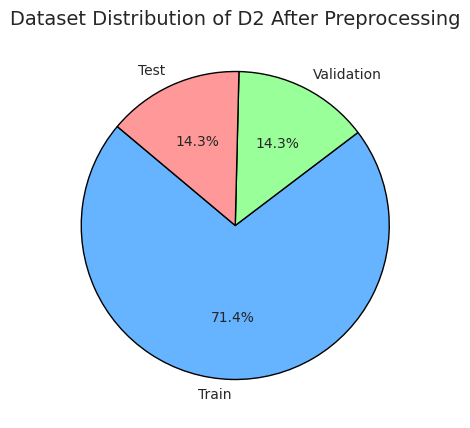

In [ ]:
plot_dataset_distribution(d2_train, d2_val, d2_test, labels=['Train', 'Validation', 'Test'],
                          title='Dataset Distribution of D2 After Preprocessing')

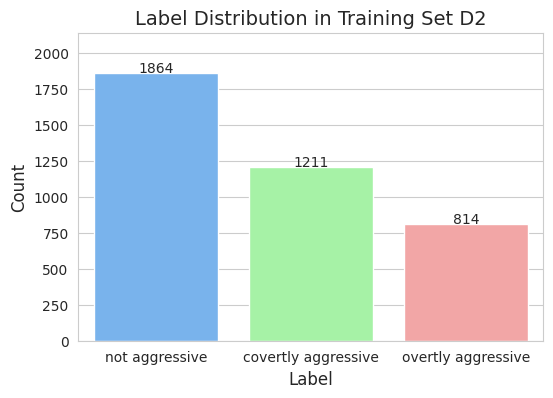

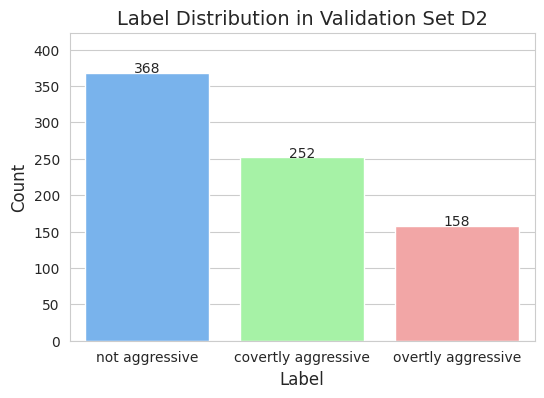

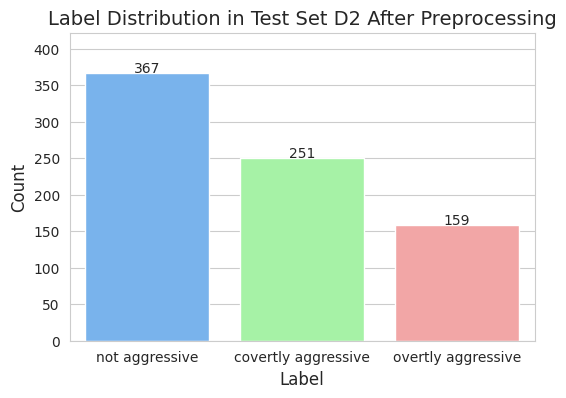

In [ ]:
# Plot for each dataset
plot_label_distribution(d2_train, 'Label Distribution in Training Set D2')
plot_label_distribution(d2_val, 'Label Distribution in Validation Set D2')
plot_label_distribution(d2_test, 'Label Distribution in Test Set D2 After Preprocessing')

##D3

In [ ]:

print("Please upload files for D3 train dataset:")
d3_train= files.upload()
d3_train= next(iter(d3_train))
d3_train=pd.read_csv(d3_train)

print("Please upload files for D3 val dataset:")
d3_val= files.upload()
d3_val= next(iter(d3_val))
d3_val=pd.read_csv(d3_val)

print("Please upload files for D3 test dataset:")
d3_test= files.upload()
d3_test= next(iter(d3_test))
d3_test=pd.read_csv(d3_test)


Please upload files for D3 train dataset:


Saving new_TRAC_train_set.csv to new_TRAC_train_set.csv
Please upload files for D3 val dataset:


Saving new_TRAC_val_set.csv to new_TRAC_val_set.csv
Please upload files for D3 test dataset:


Saving new_TRAC_test_set.csv to new_TRAC_test_set.csv


In [ ]:
print("Visualize head of D3 train dataset:")
d3_train.head()

Visualize head of D3 train dataset:


,Sentence,Label
0,Mr. Prateek Nishant.....secure method?,1
1,Sane ppl couldn't do anything so far ....at le...,1
2,Moreover that idiot is fan of Terrorist Yakub ...,2
3,Shame shame & then these lowly so called educa...,2
4,I completely agree with your viewpoint.\nBut l...,0


In [ ]:
print("Visualize head of D3 validation dataset:")
d3_val.head()

Visualize head of D3 validation dataset:


,Sentence,Label
0,And Pakistani Army came and beheaded our soldi...,1
1,Indian government concentrates more on cow pro...,0
2,No because I neither share anything and everyt...,1
3,Seriously Anna Hazare should introspect before...,1
4,Hahahaha. Nice story,1


In [ ]:
print("Visualize head of D3 test dataset:")
d3_test.head()

Visualize head of D3 test dataset:


,Sentence,Label
0,#isi Agent spotted,1
1,"This post by Quora is a superb example of ""sha...",1
2,Here comes a human rights activist who's conce...,1
3,Or by one person who steals ideas from a team ...,1
4,nis video,0


In [ ]:
# Map numeric labels to descriptive labels
label_mapping_d3 = {0: 'not aggressive', 1: 'covertly aggressive', 2: 'overtly aggressive'}
d3_train['label'] = d3_train['Label'].map(label_mapping_d3)
d3_val['label'] = d3_val['Label'].map(label_mapping_d3)
d3_test['label'] = d3_test['Label'].map(label_mapping_d3)

d3_train=d3_train.rename(columns={'Sentence':'text'})
d3_val=d3_val.rename(columns={'Sentence':'text'})
d3_test=d3_test.rename(columns={'Sentence':'text'})

d3_train=d3_train.drop(columns=['Label'])
d3_val=d3_val.drop(columns=['Label'])
d3_test=d3_test.drop(columns=['Label'])

In [ ]:
d3_train.head()

,text,label
0,Mr. Prateek Nishant.....secure method?,covertly aggressive
1,Sane ppl couldn't do anything so far ....at le...,covertly aggressive
2,Moreover that idiot is fan of Terrorist Yakub ...,overtly aggressive
3,Shame shame & then these lowly so called educa...,overtly aggressive
4,I completely agree with your viewpoint.\nBut l...,not aggressive


In [ ]:

analyze_dataset(d3_train, "D3 Train")
analyze_dataset(d3_val, "D3 Validation")
analyze_dataset(d3_test, "D3 Test")

NULL values in D3 Train dataframe:
text     0
label    0
dtype: int64

Label distribution for D3 Train:
label
not aggressive         4349
covertly aggressive    3274
overtly aggressive     2172
Name: count, dtype: int64

Dataset shape: (9795, 2)

Data types:
text     object
label    object
dtype: object
--------------------------------------------------
NULL values in D3 Validation dataframe:
text     0
label    0
dtype: int64

Label distribution for D3 Validation:
label
not aggressive         543
covertly aggressive    409
overtly aggressive     272
Name: count, dtype: int64

Dataset shape: (1224, 2)

Data types:
text     object
label    object
dtype: object
--------------------------------------------------
NULL values in D3 Test dataframe:
text     0
label    0
dtype: int64

Label distribution for D3 Test:
label
not aggressive         544
covertly aggressive    410
overtly aggressive     271
Name: count, dtype: int64

Dataset shape: (1225, 2)

Data types:
text     object
label    ob

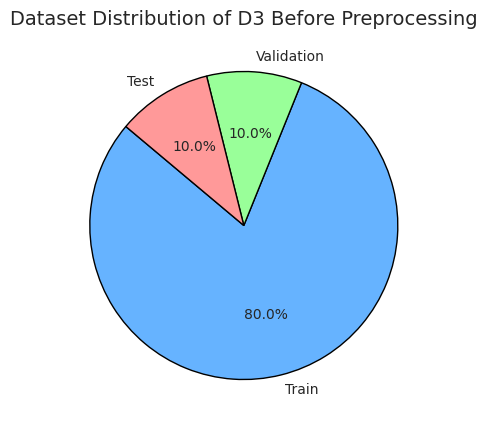

In [ ]:
plot_dataset_distribution(d3_train, d3_val, d3_test, labels=['Train', 'Validation', 'Test'],
                          title='Dataset Distribution of D3 Before Preprocessing')

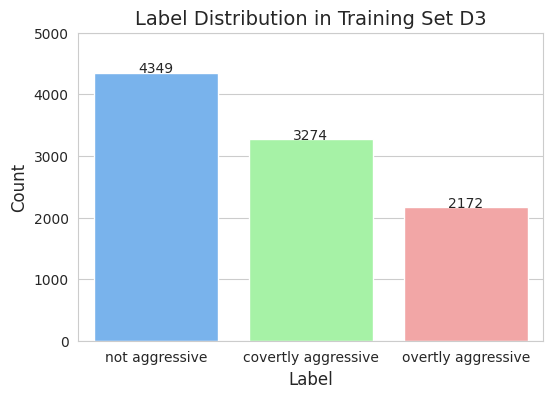

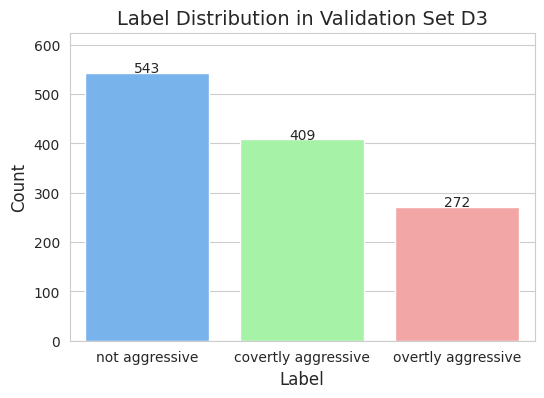

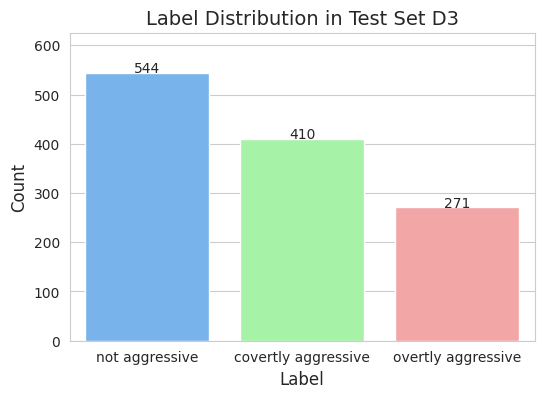

In [ ]:
# Plot for each dataset
plot_label_distribution(d3_train, 'Label Distribution in Training Set D3')
plot_label_distribution(d3_val, 'Label Distribution in Validation Set D3')
plot_label_distribution(d3_test, 'Label Distribution in Test Set D3')

PreProcessing D3

In [ ]:

d3_train['has_devanagari'] = d3_train['text'].apply(has_devanagari_script)
d3_train_eng= d3_train[d3_train['has_devanagari'] == False].copy()

devanagari_filtered_d3_train = d3_train[d3_train['has_devanagari'] == True].copy()
d3_train = d3_train_eng.drop(['has_devanagari', 'is_english'], axis=1, errors='ignore').reset_index(drop=True)

d3_test['has_devanagari'] = d3_test['text'].apply(has_devanagari_script)
d3_test_eng = d3_test[d3_test['has_devanagari'] == False].copy()

devanagari_filtered_d3_test = d3_test[d3_test['has_devanagari'] == True].copy()
d3_test = d3_test_eng.drop(['has_devanagari', 'is_english'], axis=1, errors='ignore').reset_index(drop=True)

In [ ]:
print("Number of devanagari sentences  removed", len(devanagari_filtered_d3_train))
print("Number of devanagari sentences  removed", len(devanagari_filtered_d3_test))

Number of devanagari sentences  removed 0
Number of devanagari sentences  removed 0


In [ ]:
d3_train['text']=d3_train['text'].apply(preprocess_text)
d3_val['text']=d3_val['text'].apply(preprocess_text)
d3_test['text']=d3_test['text'].apply(preprocess_text)

d2_train = d2_train.dropna(subset=['text', 'label']).reset_index(drop=True)
d2_val = d2_val.dropna(subset=['text', 'label']).reset_index(drop=True)
d2_test = d2_test.dropna(subset=['text', 'label']).reset_index(drop=True)

In [ ]:

analyze_dataset(d3_train, "D3 Train")
analyze_dataset(d3_val, "D3 Validation")
analyze_dataset(d3_test, "D3 Test")

NULL values in D3 Train dataframe:
text     0
label    0
dtype: int64

Label distribution for D3 Train:
label
not aggressive         4349
covertly aggressive    3274
overtly aggressive     2172
Name: count, dtype: int64

Dataset shape: (9795, 2)

Data types:
text     object
label    object
dtype: object
--------------------------------------------------
NULL values in D3 Validation dataframe:
text     0
label    0
dtype: int64

Label distribution for D3 Validation:
label
not aggressive         543
covertly aggressive    409
overtly aggressive     272
Name: count, dtype: int64

Dataset shape: (1224, 2)

Data types:
text     object
label    object
dtype: object
--------------------------------------------------
NULL values in D3 Test dataframe:
text     0
label    0
dtype: int64

Label distribution for D3 Test:
label
not aggressive         544
covertly aggressive    410
overtly aggressive     271
Name: count, dtype: int64

Dataset shape: (1225, 2)

Data types:
text     object
label    ob

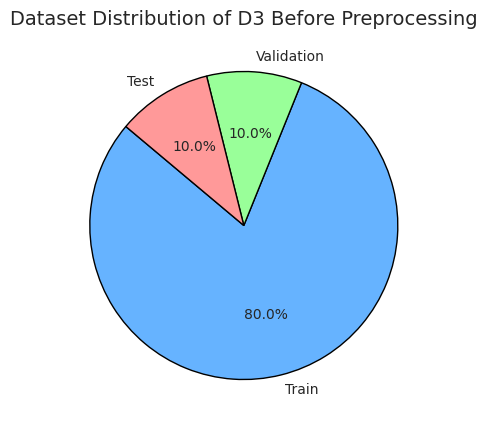

In [ ]:
plot_dataset_distribution(d3_train, d3_val, d3_test, labels=['Train', 'Validation', 'Test'],
                          title='Dataset Distribution of D3 Before Preprocessing')

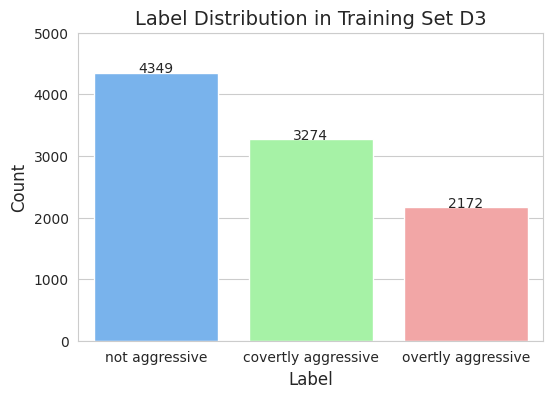

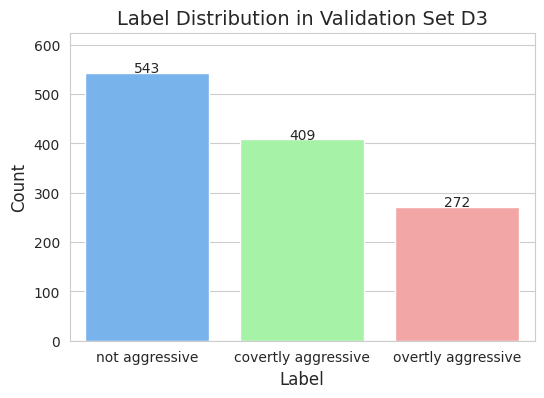

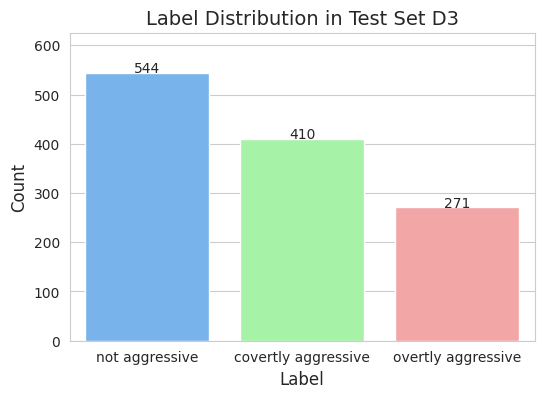

In [ ]:
# Plot for each dataset
plot_label_distribution(d3_train, 'Label Distribution in Training Set D3')
plot_label_distribution(d3_val, 'Label Distribution in Validation Set D3')
plot_label_distribution(d3_test, 'Label Distribution in Test Set D3')

##D4

In [ ]:

print("Please upload files for D4 train dataset:")
d4_train= files.upload()
d4_train= next(iter(d4_train))
d4_train=pd.read_csv(d4_train)

print("Please upload files for D4 test dataset:")
d4_test= files.upload()
d4_test= next(iter(d4_test))
d4_test=pd.read_csv(d4_test)


Please upload files for D4 train dataset:


Saving trac2_eng_train.csv to trac2_eng_train.csv
Please upload files for D4 test dataset:


Saving trac2_eng_dev.csv to trac2_eng_dev.csv


In [ ]:
print("Visualize head of D1 train dataset:")
d4_train.head()


Visualize head of D1 train dataset:


,ID,Text,Sub-task A,Sub-task B
0,C45.451,Next part,NAG,NGEN
1,C47.11,Iii8mllllllm\nMdxfvb8o90lplppi0005,NAG,NGEN
2,C33.79,🤣🤣😂😂🤣🤣🤣😂osm vedio ....keep it up...make more v...,NAG,NGEN
3,C4.1961,What the fuck was this? I respect shwetabh and...,NAG,NGEN
4,C10.153,Concerned authorities should bring arundathi R...,NAG,NGEN


In [ ]:
print("Visualize head of D1 train dataset:")
d4_test.head()

Visualize head of D1 train dataset:


,ID,Text,Sub-task A,Sub-task B
0,C7.2589,U deserve more subscribers. U really great.,NAG,NGEN
1,C68.872,Nice video....,NAG,NGEN
2,C36.762,sorry if i bother somebody.. iam a defence asp...,NAG,GEN
3,C4.1540.1,Joker was amazing....it was not glamorised !.....,NAG,NGEN
4,C59.68,Nice baro,NAG,NGEN


In [ ]:

# Then run the corrected mapping and cleaning code
label_mapping_d4 = {'NAG': 'not aggressive', 'CAG': 'covertly aggressive', 'OAG': 'overtly aggressive'}
d4_train['label'] = d4_train['Sub-task A'].map(label_mapping_d4)
d4_test['label'] = d4_test['Sub-task A'].map(label_mapping_d4)
d4_train.drop(columns=['Sub-task A','ID','Sub-task B'], inplace=True)
d4_test.drop(columns=['Sub-task A','ID','Sub-task B'], inplace=True)

d4_train.rename(columns={'Text':'text'}, inplace=True)
d4_test.rename(columns={'Text':'text'}, inplace=True)

In [ ]:
d4_train.head()

,text,label
0,Next part,not aggressive
1,Iii8mllllllm\nMdxfvb8o90lplppi0005,not aggressive
2,🤣🤣😂😂🤣🤣🤣😂osm vedio ....keep it up...make more v...,not aggressive
3,What the fuck was this? I respect shwetabh and...,not aggressive
4,Concerned authorities should bring arundathi R...,not aggressive


In [ ]:
analyze_dataset(d4_train, "D4 Train")

analyze_dataset(d4_test, "D4 Test")

NULL values in D4 Train dataframe:
text     0
label    0
dtype: int64

Label distribution for D4 Train:
label
not aggressive         3375
covertly aggressive     453
overtly aggressive      435
Name: count, dtype: int64

Dataset shape: (4263, 2)

Data types:
text     object
label    object
dtype: object
--------------------------------------------------
NULL values in D4 Test dataframe:
text     0
label    0
dtype: int64

Label distribution for D4 Test:
label
not aggressive         836
covertly aggressive    117
overtly aggressive     113
Name: count, dtype: int64

Dataset shape: (1066, 2)

Data types:
text     object
label    object
dtype: object
--------------------------------------------------


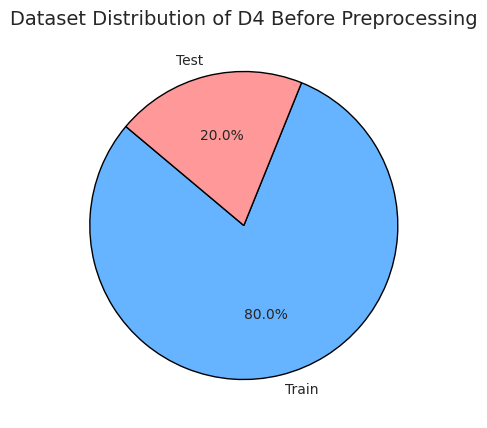

In [ ]:
plot_dataset_distribution_train_test(d4_train,  d4_test, labels=['Train',  'Test'],
                          title='Dataset Distribution of D4 Before Preprocessing')

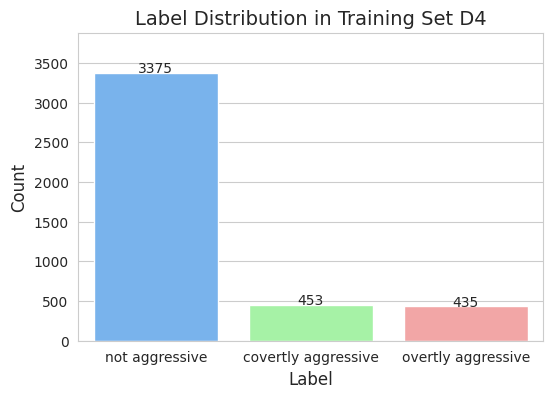

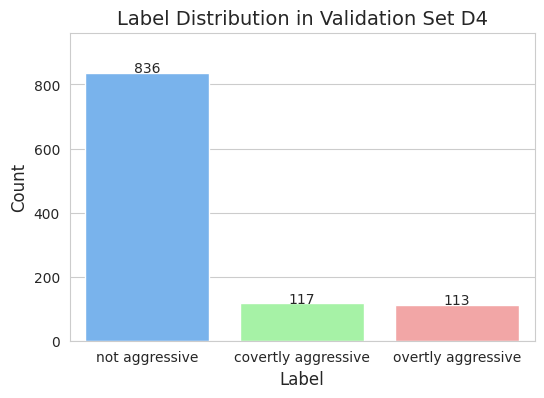

In [ ]:
# Plot for each dataset
plot_label_distribution(d4_train, 'Label Distribution in Training Set D4')
plot_label_distribution(d4_test, 'Label Distribution in Validation Set D4')

D4 after Preprocessing

In [ ]:

d4_train['has_devanagari'] = d4_train['text'].apply(has_devanagari_script)
d4_train_eng= d4_train[d4_train['has_devanagari'] == False].copy()

devanagari_filtered_d4_train = d4_train[d4_train['has_devanagari'] == True].copy()
d4_train = d4_train_eng.drop(['has_devanagari', 'is_english'], axis=1, errors='ignore').reset_index(drop=True)

d4_test['has_devanagari'] = d4_test['text'].apply(has_devanagari_script)
d4_test_eng = d4_test[d4_test['has_devanagari'] == False].copy()

devanagari_filtered_d4_test = d4_test[d4_test['has_devanagari'] == True].copy()
d4_test = d4_test_eng.drop(['has_devanagari', 'is_english'], axis=1, errors='ignore').reset_index(drop=True)



In [ ]:
print("Number of devanagari sentences  removed", len(devanagari_filtered_d4_train))
print("Number of devanagari sentences  removed", len(devanagari_filtered_d4_test))

Number of devanagari sentences  removed 14
Number of devanagari sentences  removed 0


In [ ]:
#preprocessing of datasets
d4_train['text']=d4_train['text'].apply(preprocess_text)
d4_test['text']=d4_test['text'].apply(preprocess_text)

d4_train = d4_train.dropna(subset=['text', 'label']).reset_index(drop=True)
d4_test = d4_test.dropna(subset=['text', 'label']).reset_index(drop=True)

In [ ]:
d4_test, d4_val = train_test_split(
    d4_test,
    test_size=0.5,
    random_state=42,
    stratify=d4_test['label']
)

d4_test = d4_test.reset_index(drop=True)
d4_val = d4_val.reset_index(drop=True)

In [ ]:
d4_train = d4_train.dropna(subset=['text', 'label']).reset_index(drop=True)
d4_test = d4_test.dropna(subset=['text', 'label']).reset_index(drop=True)
d4_dval = d4_val.dropna(subset=['text', 'label']).reset_index(drop=True)

In [ ]:
analyze_dataset(d4_train, "D4 Train")

analyze_dataset(d4_test, "D4 Test")

analyze_dataset(d4_val, "D4 Validation")



NULL values in D4 Train dataframe:
text     0
label    0
dtype: int64

Label distribution for D4 Train:
label
not aggressive         3364
covertly aggressive     452
overtly aggressive      433
Name: count, dtype: int64

Dataset shape: (4249, 2)

Data types:
text     object
label    object
dtype: object
--------------------------------------------------
NULL values in D4 Test dataframe:
text     0
label    0
dtype: int64

Label distribution for D4 Test:
label
not aggressive         418
covertly aggressive     58
overtly aggressive      57
Name: count, dtype: int64

Dataset shape: (533, 2)

Data types:
text     object
label    object
dtype: object
--------------------------------------------------
NULL values in D4 Validation dataframe:
text     0
label    0
dtype: int64

Label distribution for D4 Validation:
label
not aggressive         418
covertly aggressive     59
overtly aggressive      56
Name: count, dtype: int64

Dataset shape: (533, 2)

Data types:
text     object
label    obje

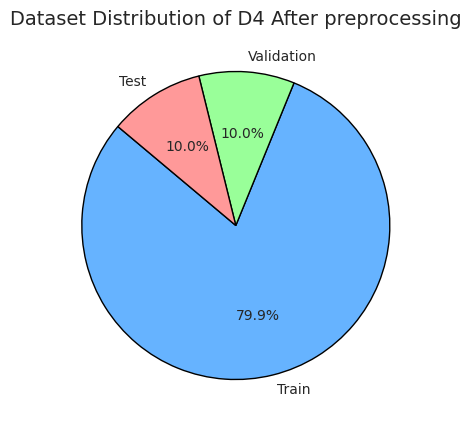

In [ ]:
plot_dataset_distribution(d4_train,d4_val,  d4_test, labels=['Train', 'Validation', 'Test'],
                          title='Dataset Distribution of D4 After preprocessing')

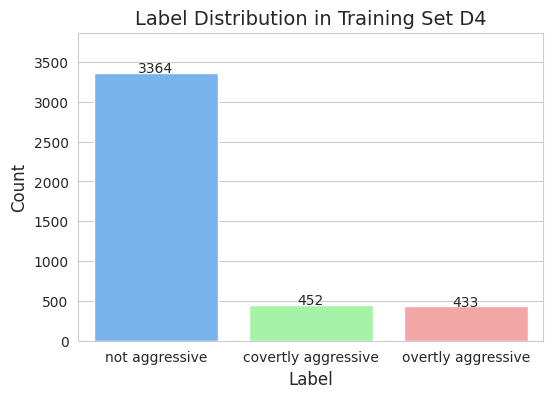

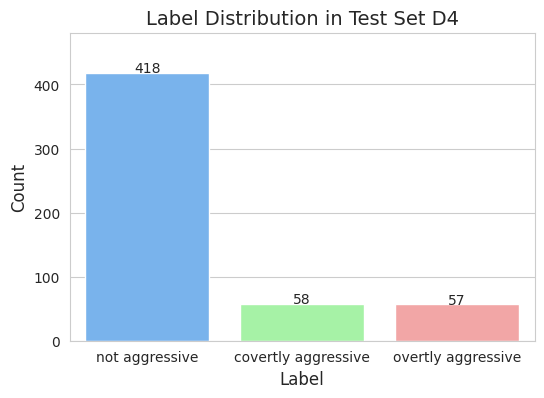

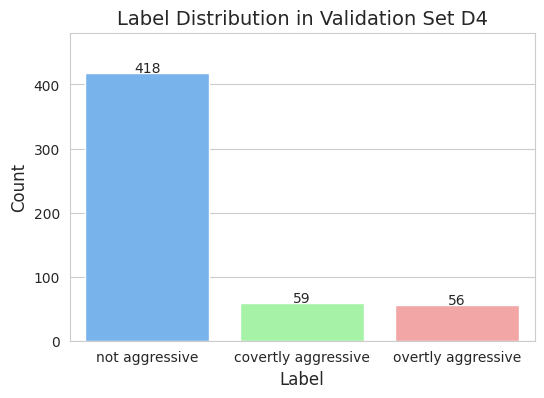

In [ ]:
plot_label_distribution(d4_train, 'Label Distribution in Training Set D4')
plot_label_distribution(d4_test, 'Label Distribution in Test Set D4')
plot_label_distribution(d4_val, 'Label Distribution in Validation Set D4')

## D5

In [ ]:

print("Please upload files for D5 train dataset:")
d5_train= files.upload()
d5_train= next(iter(d5_train))
d5_train=pd.read_csv(d5_train)

print("Please upload files for D5 test dataset:")
d5_test= files.upload()
d5_test= next(iter(d5_test))
d5_test=pd.read_csv(d5_test)

Please upload files for D5 train dataset:


Saving agr_en_train (1).csv to agr_en_train (1).csv
Please upload files for D5 test dataset:


Saving agr_en_TEST_JULIAN.csv to agr_en_TEST_JULIAN.csv


In [ ]:
print("Visualize head of D5 train dataset:")
d5_train.head()


Visualize head of D5 train dataset:


,source,text,label
0,facebook_corpus_msr_1723796,Well said sonu..you have courage to stand agai...,OAG
1,facebook_corpus_msr_466073,"Most of Private Banks ATM's Like HDFC, ICICI e...",NAG
2,facebook_corpus_msr_1493901,"Now question is, Pakistan will adhere to this?",OAG
3,facebook_corpus_msr_405512,Pakistan is comprised of fake muslims who does...,OAG
4,facebook_corpus_msr_1521685,"??we r against cow slaughter,so of course it w...",NAG


In [ ]:
print("Visualize head of D5 test dataset:")
d5_test.head()


Visualize head of D5 test dataset:


,source,text,label
0,facebook_corpus_msr_451811,The quality of re made now makes me think it i...,CAG
1,facebook_corpus_msr_334368,@siva \nHow is ur mother???\nHow is ur wife???...,NAG
2,facebook_corpus_msr_331195,Also see ....hw ur RSS activist caught in Burk...,NAG
3,facebook_corpus_msr_403402,On the death of 2 jawans in LOC CROSS FIRING\n...,NAG
4,facebook_corpus_msr_379239,Modi ho ya Manmohan singh saala yeh log kuch n...,OAG


In [ ]:

label_mapping_d5 = {'NAG': 'not aggressive', 'CAG': 'covertly aggressive', 'OAG': 'overtly aggressive'}
d5_train['label'] = d5_train['label'].map(label_mapping_d5)
d5_test['label'] = d5_test['label'].map(label_mapping_d5)

d5_train.drop(columns=['source'], inplace=True)
d5_test.drop(columns=['source'], inplace=True)



In [ ]:
analyze_dataset(d5_train, "D5 Train")

analyze_dataset(d5_test, "D5 Test")

NULL values in D5 Train dataframe:
text     0
label    0
dtype: int64

Label distribution for D5 Train:
label
not aggressive         5051
covertly aggressive    4240
overtly aggressive     2708
Name: count, dtype: int64

Dataset shape: (11999, 2)

Data types:
text     object
label    object
dtype: object
--------------------------------------------------
NULL values in D5 Test dataframe:
text     0
label    0
dtype: int64

Label distribution for D5 Test:
label
not aggressive         1233
covertly aggressive    1057
overtly aggressive      711
Name: count, dtype: int64

Dataset shape: (3001, 2)

Data types:
text     object
label    object
dtype: object
--------------------------------------------------


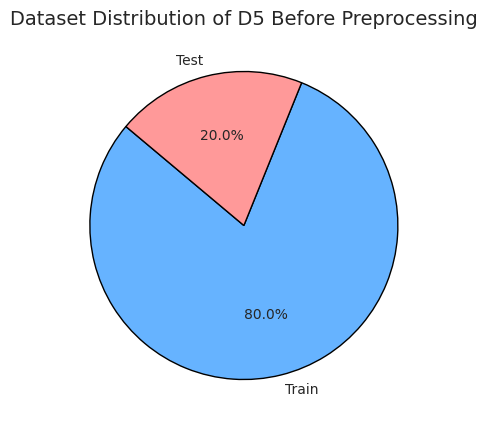

In [ ]:
plot_dataset_distribution_train_test(d5_train,  d5_test, labels=['Train',  'Test'],
                          title='Dataset Distribution of D5 Before Preprocessing')

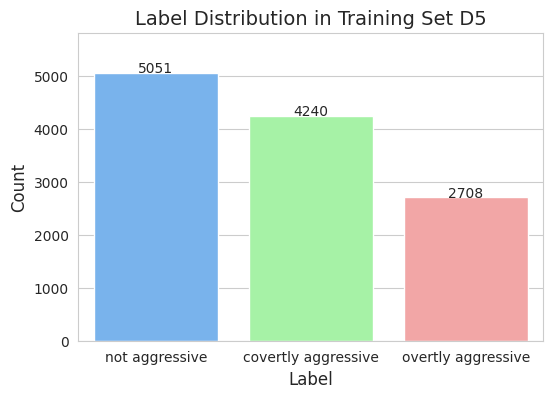

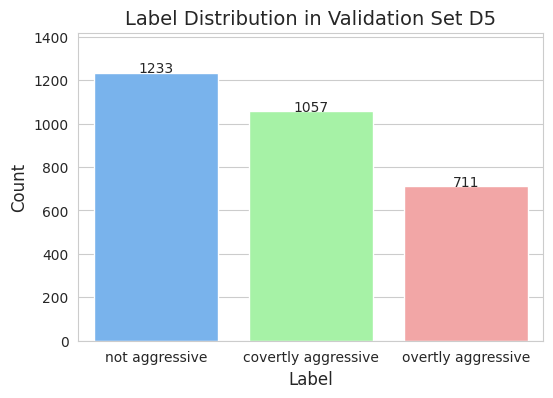

In [ ]:
# Plot for each dataset
plot_label_distribution(d5_train, 'Label Distribution in Training Set D5')
plot_label_distribution(d5_test, 'Label Distribution in Validation Set D5')

In [ ]:
d5_train['has_devanagari'] = d5_train['text'].apply(has_devanagari_script)
d5_train_eng= d5_train[d5_train['has_devanagari'] == False].copy()

devanagari_filtered_d5_train = d5_train[d5_train['has_devanagari'] == True].copy()
d5_train = d5_train_eng.drop(['has_devanagari', 'is_english'], axis=1, errors='ignore').reset_index(drop=True)

d5_test['has_devanagari'] = d5_test['text'].apply(has_devanagari_script)
d5_test_eng = d5_test[d5_test['has_devanagari'] == False].copy()

devanagari_filtered_d5_test = d5_test[d5_test['has_devanagari'] == True].copy()
d5_test = d5_test_eng.drop(['has_devanagari', 'is_english'], axis=1, errors='ignore').reset_index(drop=True)


In [ ]:
print("Number of devanagari sentences  removed", len(devanagari_filtered_d5_train))
print("Number of devanagari sentences  removed", len(devanagari_filtered_d5_test))

Number of devanagari sentences  removed 27
Number of devanagari sentences  removed 14


In [ ]:
#preprocessing of datasets
d5_train['text']=d5_train['text'].apply(preprocess_text)
d5_test['text']=d5_test['text'].apply(preprocess_text)

d5_train = d5_train.dropna(subset=['text', 'label']).reset_index(drop=True)
d5_test = d5_test.dropna(subset=['text', 'label']).reset_index(drop=True)

In [ ]:
d5_test, d5_val = train_test_split(
    d5_test,
    test_size=0.5,
    random_state=42,
    stratify=d5_test['label']
)

d5_test = d5_test.reset_index(drop=True)
d5_val = d5_val.reset_index(drop=True)

In [ ]:
analyze_dataset(d5_train, "D5 Train")
analyze_dataset(d5_val, "D5 Validation")
analyze_dataset(d5_test, "D5 Test")

NULL values in D5 Train dataframe:
text     0
label    0
dtype: int64

Label distribution for D5 Train:
label
not aggressive         5043
covertly aggressive    4223
overtly aggressive     2706
Name: count, dtype: int64

Dataset shape: (11972, 2)

Data types:
text     object
label    object
dtype: object
--------------------------------------------------
NULL values in D5 Validation dataframe:
text     0
label    0
dtype: int64

Label distribution for D5 Validation:
label
not aggressive         616
covertly aggressive    523
overtly aggressive     355
Name: count, dtype: int64

Dataset shape: (1494, 2)

Data types:
text     object
label    object
dtype: object
--------------------------------------------------
NULL values in D5 Test dataframe:
text     0
label    0
dtype: int64

Label distribution for D5 Test:
label
not aggressive         616
covertly aggressive    522
overtly aggressive     355
Name: count, dtype: int64

Dataset shape: (1493, 2)

Data types:
text     object
label    o

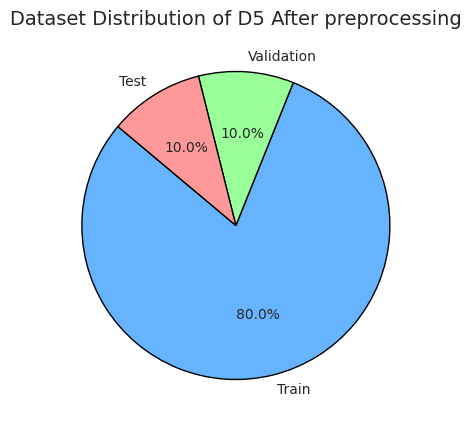

In [ ]:
plot_dataset_distribution(d5_train,d5_val, d5_test, labels=['Train', 'Validation', 'Test'],
                          title='Dataset Distribution of D5 After preprocessing')

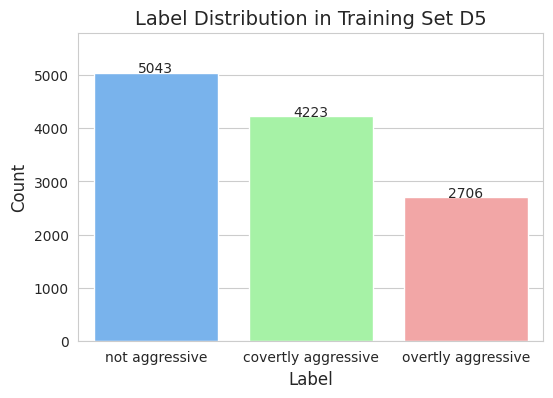

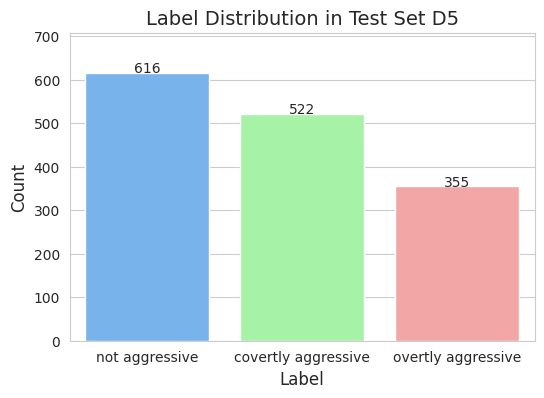

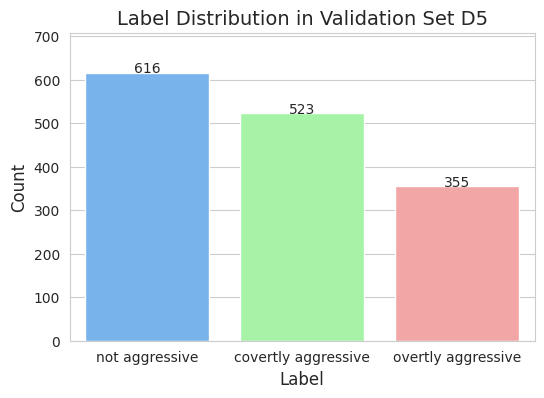

In [ ]:
plot_label_distribution(d5_train, 'Label Distribution in Training Set D5')
plot_label_distribution(d5_test, 'Label Distribution in Test Set D5')
plot_label_distribution(d5_val, 'Label Distribution in Validation Set D5')


In [ ]:
import pandas as pd

datasets = [d1_train, d2_train, d3_train, d4_train, d5_train]
dataset_names = ['d1_train', 'd2_train', 'd3_train', 'd4_train', 'd5_train']

print("Checking column consistency:")
for i, (df, name) in enumerate(zip(datasets, dataset_names)):
    print(f"{name}: columns = {df.columns.tolist()}, shape = {df.shape}")

combined_train = pd.concat(datasets, ignore_index=True)

Checking column consistency:
d1_train: columns = ['text', 'label'], shape = (1599, 2)
d2_train: columns = ['text', 'label'], shape = (3889, 2)
d3_train: columns = ['text', 'label'], shape = (9795, 2)
d4_train: columns = ['text', 'label'], shape = (4249, 2)
d5_train: columns = ['text', 'label'], shape = (11972, 2)


In [ ]:
combined_train_shuffled = combined_train.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
datasets = [d1_val, d2_val, d3_val, d4_val, d5_val]
dataset_names = ['d1_val', 'd2_val', 'd3_val', 'd4_val', 'd5_val']

print("Checking column consistency:")
for i, (df, name) in enumerate(zip(datasets, dataset_names)):
    print(f"{name}: columns = {df.columns.tolist()}, shape = {df.shape}")

combined_dev = pd.concat(datasets, ignore_index=True)

Checking column consistency:
d1_val: columns = ['text', 'label'], shape = (200, 2)
d2_val: columns = ['text', 'label'], shape = (778, 2)
d3_val: columns = ['text', 'label'], shape = (1224, 2)
d4_val: columns = ['text', 'label'], shape = (533, 2)
d5_val: columns = ['text', 'label'], shape = (1494, 2)


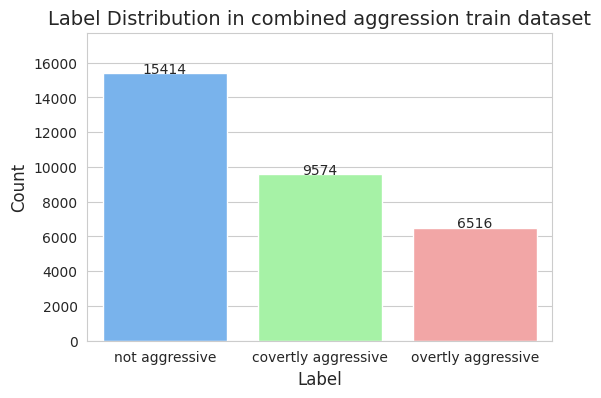

In [ ]:
plot_label_distribution(combined_train, 'Label Distribution in combined aggression train dataset')

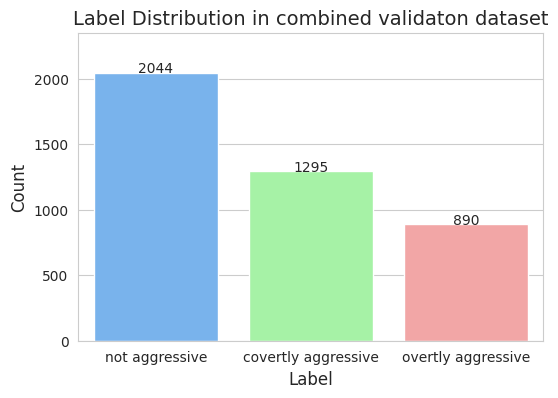

In [ ]:
plot_label_distribution(combined_dev, 'Label Distribution in combined validaton dataset')

In [ ]:
from sklearn.utils import resample

min_count = combined_train['label'].value_counts().min()


balanced_train_dfs = [resample(combined_train[combined_train['label'] == lbl], replace=False, n_samples=min_count, random_state=42)
                       for lbl in combined_train['label'].unique()]
balanced_train_df = pd.concat(balanced_train_dfs).sample(frac=1, random_state=42).reset_index(drop=True)

print("Balanced Label Distribution:\n", balanced_train_df['label'].value_counts())

Balanced Label Distribution:
 label
not aggressive         6516
covertly aggressive    6516
overtly aggressive     6516
Name: count, dtype: int64


In [ ]:

analyze_dataset(combined_dev, "Cyber bullying val dataset")

NULL values in Cyber bullying val dataset dataframe:
text     0
label    0
dtype: int64

Label distribution for Cyber bullying val dataset:
label
not aggressive         2044
covertly aggressive    1295
overtly aggressive      890
Name: count, dtype: int64

Dataset shape: (4229, 2)

Data types:
text     object
label    object
dtype: object
--------------------------------------------------


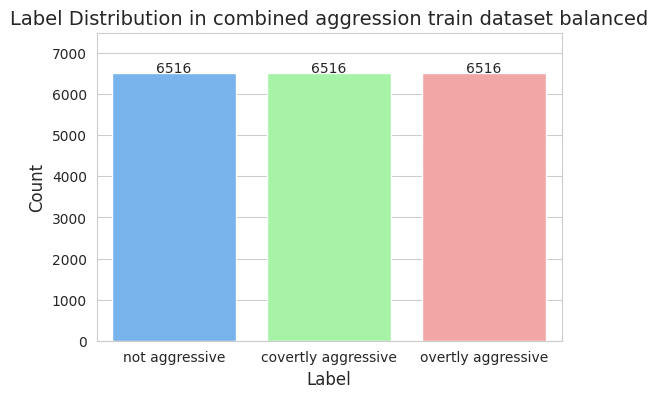

In [ ]:
plot_label_distribution(balanced_train_df, 'Label Distribution in combined aggression train dataset balanced')

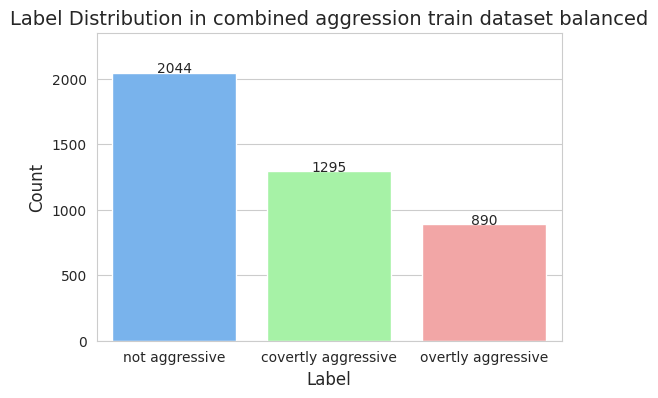

In [ ]:
plot_label_distribution(combined_dev, 'Label Distribution in combined aggression train dataset balanced')

In [ ]:
# Save the DataFrame to a CSV file
# Download it using Google Colab's files module
combined_dev.to_csv("dev_agg.csv", index=False)
from google.colab import files
files.download("dev_agg.csv")

combined_train.to_csv("train_agg.csv", index=False)
from google.colab import files
files.download("train_agg.csv")

d1_test.to_csv("d1_test.csv", index=False)
from google.colab import files
files.download("d1_test.csv")

d2_test.to_csv("d2_test.csv", index=False)
from google.colab import files
files.download("d2_test.csv")

d3_test.to_csv("d3_test.csv", index=False)
from google.colab import files
files.download("d3_test.csv")

d4_test.to_csv("d4_test.csv", index=False)
from google.colab import files
files.download("d4_test.csv")

d5_test.to_csv("d5_test.csv", index=False)
from google.colab import files
files.download("d5_test.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##CYBER BULLYING

In [ ]:
def plot_label_distribution_cyb(df, title):
    """
    Plots a bar chart showing the distribution of labels in a dataset.

    Parameters:
    - df: Dataset (DataFrame)
    - title: Title of the bar chart
    """
    sns.set_style("whitegrid")
    colors = ['#66b3ff','#99ff99','#ff9999','#ffcc99','#ff99cc','#c2c2f0']
    plt.figure(figsize=(10,4))
    ax = sns.countplot(x='label', data=df, palette=colors, order=['religion','age','gender','ethnicity','not_cyberbullying','other_cyberbullying'])

    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width()/2., height + 0.2, int(height), ha="center", fontsize=10)

    plt.title(title, fontsize=14)
    plt.ylabel('Count', fontsize=12)
    plt.xlabel('Label', fontsize=12)
    plt.xticks(fontsize=10, rotation=45)
    plt.yticks(fontsize=10)
    plt.ylim(0, max(df['label'].value_counts())*1.15)
    plt.tight_layout()
    plt.show()

In [ ]:
# Split data: 70% train, 15% test, 15% val
def split_data(df):
    # First split: 85% train+val, 15% test
    train_val, test = train_test_split(df, test_size=0.15, random_state=42, stratify=df['label'])

    # Second split: 70% train, 15% val (from remaining 85%)
    train, val = train_test_split(train_val, test_size=0.176, random_state=42, stratify=train_val['label'])

    print(f"Train: {len(train)}, Test: {len(test)}, Val: {len(val)}")
    return train, test, val

In [ ]:

print("Please upload files for cyb train dataset:")
cyb_df= files.upload()
cyb_df= next(iter(cyb_df))
cyb_df=pd.read_csv(cyb_df)


Please upload files for cyb train dataset:


Saving cyberbullying_tweets.csv to cyberbullying_tweets.csv


In [ ]:
print("Visualize head of Cyber bullying  dataset:")
cyb_df.head()

Visualize head of Cyber bullying  dataset:


,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [ ]:
cyb_df = cyb_df.rename(columns={'tweet_text': 'text', 'cyberbullying_type': 'label'})

In [ ]:
analyze_dataset(cyb_df, "Cuber bullying dataset")

NULL values in Cuber bullying dataset dataframe:
text     0
label    0
dtype: int64

Label distribution for Cuber bullying dataset:
label
religion               7998
age                    7992
gender                 7973
ethnicity              7961
not_cyberbullying      7945
other_cyberbullying    7823
Name: count, dtype: int64

Dataset shape: (47692, 2)

Data types:
text     object
label    object
dtype: object
--------------------------------------------------


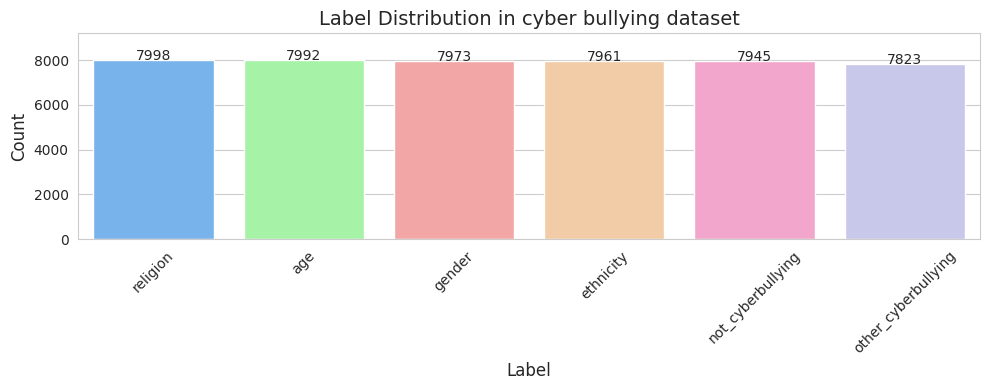

In [ ]:
plot_label_distribution_cyb(cyb_df, 'Label Distribution in cyber bullying dataset')

In [ ]:
cyb_df['has_devanagari'] = cyb_df['text'].apply(has_devanagari_script)
cyb_df_eng= cyb_df[cyb_df['has_devanagari'] == False].copy()

devanagari_filtered_cyb = cyb_df[cyb_df['has_devanagari'] == True].copy()
cyb_df = cyb_df_eng.drop(['has_devanagari', 'is_english'], axis=1, errors='ignore').reset_index(drop=True)

In [ ]:
print("Number of devanagari sentences  removed", len(devanagari_filtered_cyb))

Number of devanagari sentences  removed 12


In [ ]:
#preprocessing of datasets
cyb_df['text']=cyb_df['text'].apply(preprocess_text)

cyb_df = cyb_df.dropna(subset=['text', 'label']).reset_index(drop=True)

In [ ]:

cyb_train, cyb_test, cyb_val = split_data(cyb_df)


Train: 33395, Test: 7152, Val: 7133


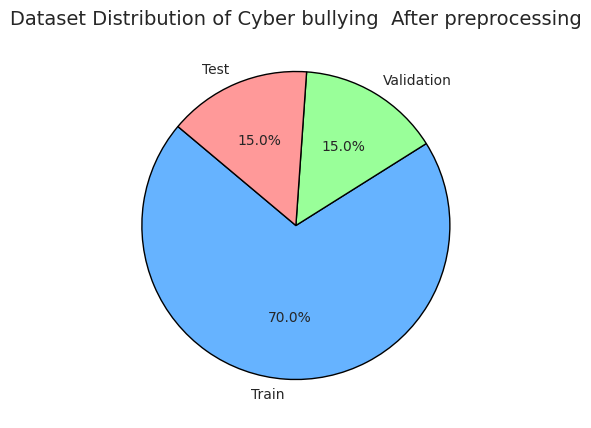

In [ ]:
plot_dataset_distribution(cyb_train,cyb_val, cyb_test, labels=['Train', 'Validation', 'Test'],
                          title='Dataset Distribution of Cyber bullying  After preprocessing')

In [ ]:
cyb_train = cyb_train.dropna(subset=['text']).reset_index(drop=True)
cyb_test = cyb_test.dropna(subset=['text']).reset_index(drop=True)
cyb_val = cyb_val.dropna(subset=['text']).reset_index(drop=True)

In [ ]:
analyze_dataset(cyb_train, "Cyber bullying train dataset")
analyze_dataset(cyb_test, "Cyber bullying test dataset")
analyze_dataset(cyb_val, "Cyber bullying val dataset")

NULL values in Cyber bullying train dataset dataframe:
text     0
label    0
dtype: int64

Label distribution for Cyber bullying train dataset:
label
age                    5597
religion               5593
gender                 5584
ethnicity              5576
not_cyberbullying      5565
other_cyberbullying    5480
Name: count, dtype: int64

Dataset shape: (33395, 2)

Data types:
text     object
label    object
dtype: object
--------------------------------------------------
NULL values in Cyber bullying test dataset dataframe:
text     0
label    0
dtype: int64

Label distribution for Cyber bullying test dataset:
label
age                    1199
religion               1198
gender                 1196
ethnicity              1194
not_cyberbullying      1192
other_cyberbullying    1173
Name: count, dtype: int64

Dataset shape: (7152, 2)

Data types:
text     object
label    object
dtype: object
--------------------------------------------------
NULL values in Cyber bullying val dataset

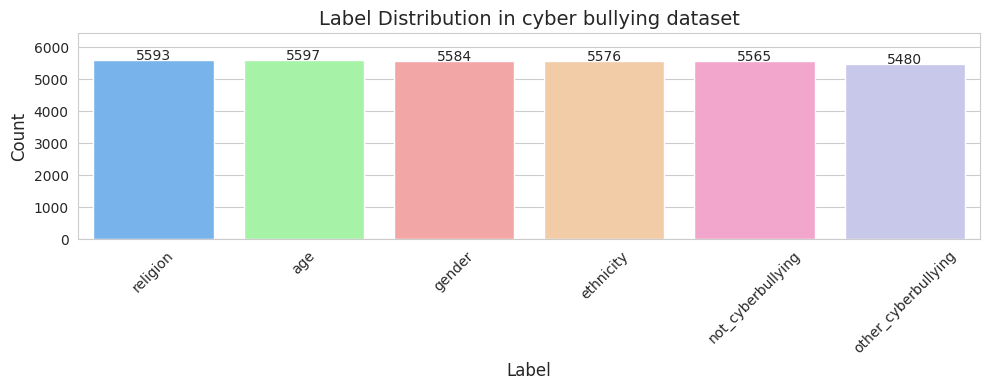

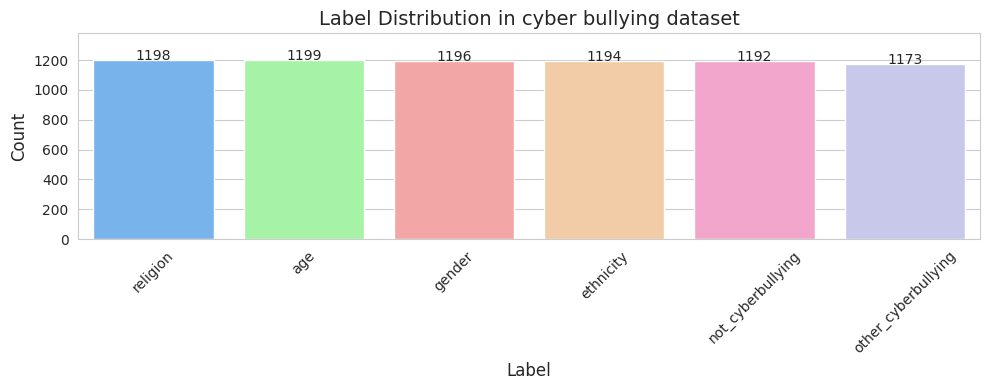

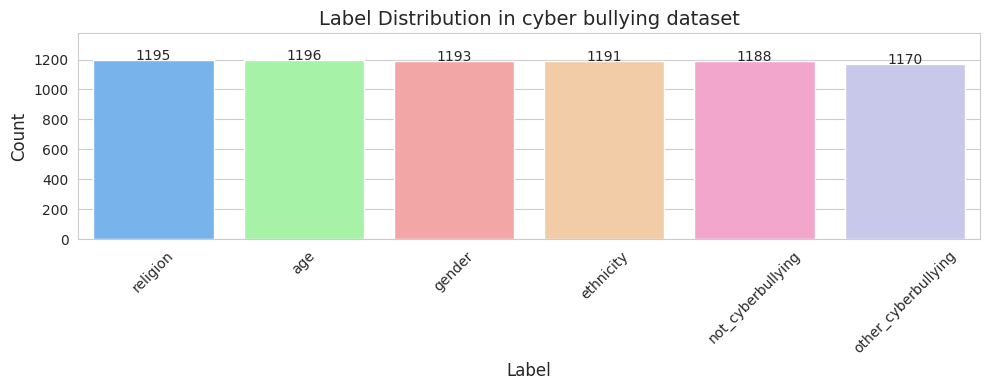

In [ ]:
plot_label_distribution_cyb(cyb_train, 'Label Distribution in cyber bullying dataset')
plot_label_distribution_cyb(cyb_test, 'Label Distribution in cyber bullying dataset')
plot_label_distribution_cyb(cyb_val, 'Label Distribution in cyber bullying dataset')

In [ ]:
cyb_train.to_csv("cyb_train.csv", index=False)
files.download("cyb_train.csv")

cyb_test.to_csv("cyb_test.csv", index=False)
files.download("cyb_test.csv")

cyb_val.to_csv("cyb_val.csv", index=False)
files.download("cyb_val.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from sklearn.utils import resample
# Get minimum class count
min_count = cyb_train['label'].value_counts().min()

balanced_train_dfs = [resample(cyb_train[cyb_train['label'] == lbl], replace=False, n_samples=min_count, random_state=42)
                       for lbl in cyb_train['label'].unique()]
balanced_train_df = pd.concat(balanced_train_dfs).sample(frac=1, random_state=42).reset_index(drop=True)

print("Balanced Label Distribution:\n", balanced_train_df['label'].value_counts())

Balanced Label Distribution:
 label
other_cyberbullying    5480
not_cyberbullying      5480
age                    5480
religion               5480
gender                 5480
ethnicity              5480
Name: count, dtype: int64


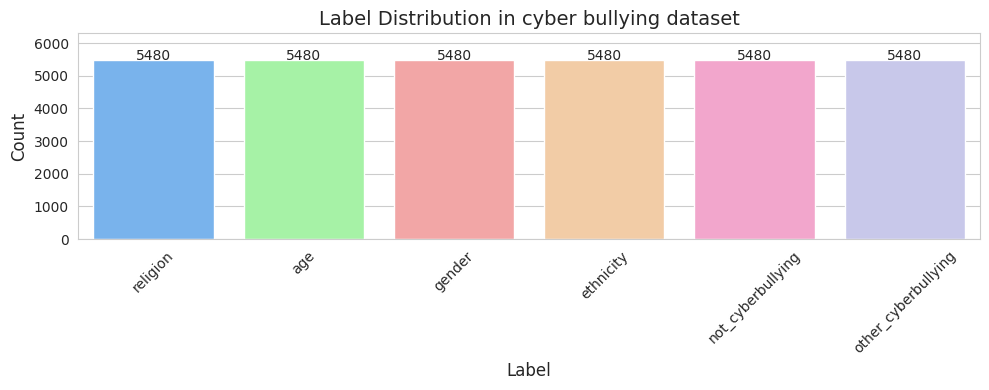

In [ ]:
plot_label_distribution_cyb(balanced_train_df, 'Label Distribution in cyber bullying dataset')

#Process D7 dataset for Multi-Task Leraning

The cyberbullying dataset further preprocessed by previous  researcher and removed label other_cyber bullying and made 4

In [ ]:

print("Please upload files for cyb train dataset:")
cyb_df_d7= files.upload()
cyb_df_d7= next(iter(cyb_df_d7))
cyb_df_d7=pd.read_csv(cyb_df_d7)

Please upload files for cyb train dataset:


Saving cb_data.csv to cb_data.csv


In [ ]:

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www.\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return  text

In [ ]:
cyb_df_d7['text'] = cyb_df_d7['text'].apply(preprocess_text)

In [ ]:

from sklearn.model_selection import train_test_split

cb_train_d7, cb_test_dev_d7 = train_test_split(cyb_df_d7, test_size=0.25, random_state=42)

cb_dev_d7 = cb_test_dev_d7.sample(n=2000, random_state=42)
cb_test_d7 = cb_test_dev_d7.drop(cb_dev_d7.index)


In [ ]:
analyze_dataset(cb_train_d7, "Cyber bullying train dataset")
analyze_dataset(cb_test_d7, "Cyber bullying test dataset")
analyze_dataset(cb_dev_d7, "Cyber bullying val dataset")

NULL values in Cyber bullying train dataset dataframe:
text     0
label    0
dtype: int64

Label distribution for Cyber bullying train dataset:
label
not_cyberbullying    37408
gender/sexual        12836
ethnicity/race       12718
religion             12030
Name: count, dtype: int64

Dataset shape: (74992, 2)

Data types:
text     object
label    object
dtype: object
--------------------------------------------------
NULL values in Cyber bullying test dataset dataframe:
text     0
label    0
dtype: int64

Label distribution for Cyber bullying test dataset:
label
not_cyberbullying    11543
ethnicity/race        3954
gender/sexual         3849
religion              3652
Name: count, dtype: int64

Dataset shape: (22998, 2)

Data types:
text     object
label    object
dtype: object
--------------------------------------------------
NULL values in Cyber bullying val dataset dataframe:
text     0
label    0
dtype: int64

Label distribution for Cyber bullying val dataset:
label
not_cyberbully

In [ ]:
# Get minimum class count
min_count = cb_train_d7['label'].value_counts().min()

cb_balanced_train_dfs = [resample(cb_train_d7[cb_train_d7['label'] == lbl], replace=False, n_samples=min_count, random_state=42)
                       for lbl in cb_train_d7['label'].unique()]
cb_balanced_train_df = pd.concat(cb_balanced_train_dfs).sample(frac=1, random_state=42).reset_index(drop=True)

print("Balanced Label Distribution:\n", cb_balanced_train_df['label'].value_counts())

Balanced Label Distribution:
 label
ethnicity/race       12030
gender/sexual        12030
religion             12030
not_cyberbullying    12030
Name: count, dtype: int64


In [ ]:
def plot_label_distribution_cyb_d7(df, title):
    """
    Plots a bar chart showing the distribution of labels in a dataset.

    Parameters:
    - df: Dataset (DataFrame)
    - title: Title of the bar chart
    """
    sns.set_style("whitegrid")
    colors = ['#66b3ff','#99ff99','#ff9999','#ffcc99']
    plt.figure(figsize=(10,4))
    ax = sns.countplot(x='label', data=df, palette=colors, order=['ethnicity/race','gender/sexual','religion','not_cyberbullying'])
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width()/2., height + 0.2, int(height), ha="center", fontsize=10)

    plt.title(title, fontsize=14)
    plt.ylabel('Count', fontsize=12)
    plt.xlabel('Label', fontsize=12)
    plt.xticks(fontsize=10, rotation=45)
    plt.yticks(fontsize=10)
    plt.ylim(0, max(df['label'].value_counts())*1.15)
    plt.tight_layout()
    plt.show()

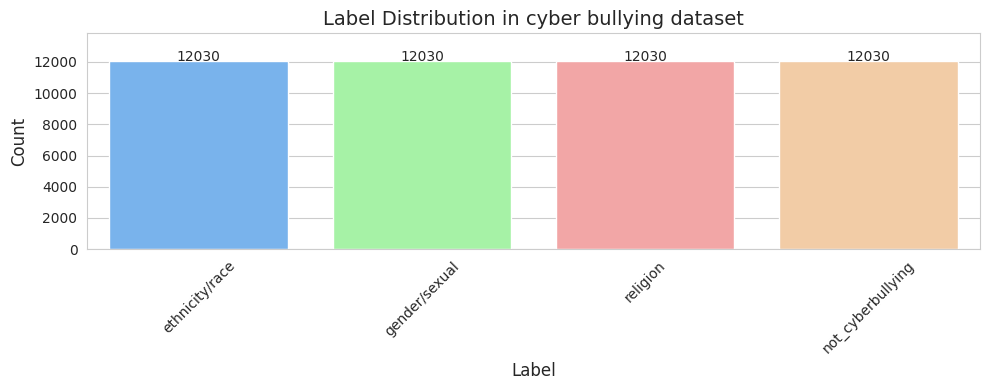

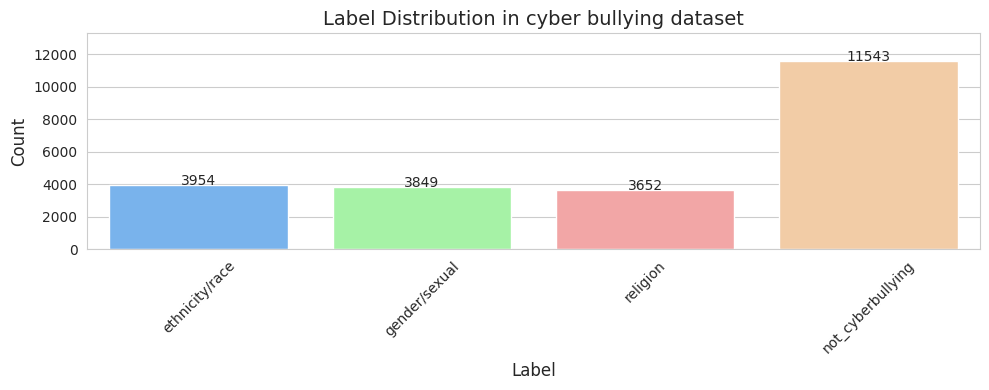

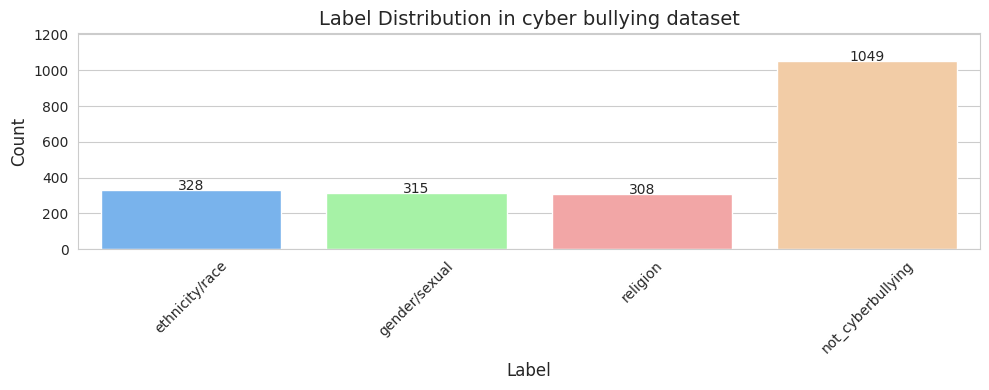

In [ ]:
plot_label_distribution_cyb_d7(cb_balanced_train_df, 'Label Distribution in cyber bullying dataset')
plot_label_distribution_cyb_d7(cb_test_d7, 'Label Distribution in cyber bullying dataset')
plot_label_distribution_cyb_d7(cb_dev_d7, 'Label Distribution in cyber bullying dataset')